## **풀이방법**
* feature을 조정하고 모델을 설정 한후 파라미터 튜닝을 하려고 하였으나 시간이 오래 걸려, 적합한 모델을 설정하고 파라미터 튜닝을 하고 feature engineering을 실시하였음. <br>
(그래서 모델 설정 풀이는 이전에 모델 설정과 앙상블 기법 사용, 최적의 파라미터 튜닝을 하여서 생략함.)

1. EDA
  * feature engineering <br>
    1. 중복된 컬럼 제거
    2. 비슷한 칼럼 한 컬럼으로 label화시키기
  * 이상치 탐지후 정규화
2. 모델 설정 후 학습(lgbm, xgb model 사용)
3. 학습 향상을 위해 앙상블 모델(stacking) 사용
4. permutation Importance를 써서 stacking 모델에 맞는 feature Importance 확인 후 중요도가 0미만인 것 제거 후 다시 feature을 조정 한 후 위 방법 다시 실행.
5. test 데이터에 적용 후 submit 파일로 대입시킨 후 제출





## EDA

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn
!pip install catboost

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
Mounted at /content/drive


## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/모의경진대회/대부업체 고객 데이터 통한 채무 불이행 예측/data/train.csv')
df.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [ ]:
# 결측치 확인
# Trnaspose를 이용해 깔끔하게 보이게함.
pd.DataFrame(df.isna().sum()).rename(columns={0:'Non-Null Count'}).T

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
Non-Null Count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Feature engineering
1. test data도 불러와 같이 설정해줘야함
2. 중복된 것은 제거하고 비슷한 피처끼리 합침.
3. 파생 변수를 만들어준다. <br>
원리금 이자액(prncp) = 소득 대비 부채비율(dti) * 연 소득(annual_inc) / 100 <br>
대출 이자액(loan_interst) = 대출금(funded_amnt) * 이자율(int_rate) <br>
3. 그전에 feature마다 제대로 된 feature인지 확인해봐야한다


In [ ]:
# test date 불러오기
# df = train, df2 = test
df2 = pd.read_csv('/content/drive/MyDrive/모의경진대회/대부업체 고객 데이터 통한 채무 불이행 예측/data/test.csv')
df2

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,ID
0,0.1449,16380.0,26.08,0,0,1,3486,10,0,0,0,9214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8100,8100.0,0.00,1,4,278.78,0.311,0.0,0.0,460.40,700,704,0
1,0.1899,65000.0,13.97,0,0,0,25305,20,0,0,0,115612,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,20000,20000.0,0.00,0,10,518.71,0.885,0.0,0.0,4866.68,675,679,1
2,0.1049,53000.0,23.28,0,0,0,10910,21,0,0,0,33017,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,10000,10000.0,16.25,1,7,324.98,0.580,0.0,0.0,1451.06,675,679,2
3,0.1757,71800.0,30.32,0,0,0,42423,26,0,0,0,152515,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,27200,27200.0,0.00,0,16,684.36,0.701,0.0,0.0,7068.11,665,669,3
4,0.2020,50000.0,25.61,0,2,0,21703,24,0,0,0,135282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,22000,22000.0,0.00,0,13,585.32,0.622,0.0,0.0,7754.20,710,714,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35811,0.1049,110000.0,9.02,0,0,1,8991,33,0,0,0,17468,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,12000,12000.0,0.00,1,13,389.98,0.346,0.0,0.0,1406.13,665,669,35811
35812,0.0824,45000.0,32.56,1,0,0,20966,29,0,0,0,24802,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,5000,5000.0,0.00,1,9,157.24,0.690,0.0,0.0,495.70,705,709,35812
35813,0.1368,49000.0,17.60,0,0,0,5597,7,0,0,0,20691,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6000,6000.0,0.00,1,7,204.14,0.333,0.0,0.0,1355.06,705,709,35813
35814,0.1139,84852.0,9.96,0,0,1,7184,13,0,0,0,31396,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.00,1,8,329.24,0.352,0.0,0.0,1615.15,725,729,35814


In [ ]:
# funded_amnt와 funded_amnt_inv / out_prncp 와 out_prncp_inv 는 중복이 되므로 하나는 제거한다.
df = df.drop(['funded_amnt_inv', 'out_prncp_inv'], axis=1)
df2 = df2.drop(['funded_amnt_inv', 'out_prncp_inv'], axis=1)
df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,0.0,1,18,37.74,0.076,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,0.0,1,8,269.52,0.447,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,0.0,1,7,168.45,0.880,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,0.0,1,12,510.27,0.457,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,0.0,1,8,335.45,0.416,0.0,871.04,660,664,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,11255,21,1,0,0,26570,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,20000,0.0,1,13,718.75,0.780,0.0,5373.29,660,664,1
99996,0.0890,65000.0,2.88,0,0,0,2105,12,0,0,0,6138,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6000,0.0,1,7,190.52,0.120,0.0,835.66,765,769,0
99997,0.1349,46000.0,32.12,0,1,0,8998,20,0,0,0,96531,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,6400,0.0,1,19,217.16,0.643,0.0,1261.67,665,669,0
99998,0.2115,31000.0,4.53,0,1,0,3875,4,0,0,0,3875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5500,0.0,1,3,207.64,0.731,0.0,1357.69,710,714,1


### 비슷한 컬럼 합치기

In [ ]:
#emp_length1 ~ 12
df['emp_length'] = 0

for idx, column in enumerate(df.loc[:,'emp_length1':'emp_length12'].columns,1):
  for i, data in enumerate(df[column]):
    if data == 1:
      df['emp_length'][i] = idx

df = df.drop(df.loc[:,'emp_length1':'emp_length12'].columns, axis=1)

In [ ]:
#home_ownership1 ~ 6
df['home_ownership'] = 0

for idx, column in enumerate(df.loc[:,'home_ownership1':'home_ownership6'].columns,1):
    for i, data in enumerate(df[column]):
        if data == 1:
            df['home_ownership'][i] = idx

df = df.drop(df.loc[:,'home_ownership1':'home_ownership6'].columns, axis=1)

In [ ]:
#verification_status1 ~ 3
df['verification_status'] = 0

for idx, column in enumerate(df.loc[:,'verification_status1':'verification_status3'].columns,1):
    for i, data in enumerate(df[column]):
        if data == 1:
            df['verification_status'][i] = idx

df = df.drop(df.loc[:,'verification_status1':'verification_status3'].columns, axis=1)

In [ ]:
#purpose1 ~ 14
df['purpose'] = 0

for idx, column in enumerate(df.loc[:,'purpose1':'purpose14'].columns,1):
    for i, data in enumerate(df[column]):
        if data == 1:
            df['purpose'][i] = idx

df = df.drop(df.loc[:,'purpose1':'purpose14'].columns, axis=1)

In [ ]:
#initial_list_status1 ~ 2
df['initial_list_status'] = 0

for idx, column in enumerate(df.loc[:,'initial_list_status1':'initial_list_status2'].columns,1):
    for i, data in enumerate(df[column]):
        if data == 1:
            df['initial_list_status'][i] = idx
            
df = df.drop(df.loc[:,'initial_list_status1':'initial_list_status2'].columns, axis=1)

In [ ]:
#mths_since_last_delinq1 ~ 11
df['mths_since_last_delinq'] = 0

for idx, column in enumerate(df.loc[:,'mths_since_last_delinq1':'mths_since_last_delinq11'].columns,1):
    for i, data in enumerate(df[column]):
        if data == 1:
            df['mths_since_last_delinq'][i] = idx

df = df.drop(df.loc[:,'mths_since_last_delinq1':'mths_since_last_delinq11'].columns, axis=1)

In [ ]:
df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1200,0.0,1,18,37.74,0.076,0.0,157.94,765,769,0,1,6,2,2,2,1
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,8000,0.0,1,8,269.52,0.447,0.0,1702.42,665,669,0,2,6,3,3,2,1
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,5000,0.0,1,7,168.45,0.880,0.0,1066.64,670,674,0,4,6,2,3,2,11
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,15000,0.0,1,12,510.27,0.457,0.0,1256.24,680,684,1,3,2,3,3,2,5
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,10000,0.0,1,8,335.45,0.416,0.0,871.04,660,664,1,4,6,2,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,11255,21,1,0,0,26570,0,0,0,20000,0.0,1,13,718.75,0.780,0.0,5373.29,660,664,1,7,6,3,3,2,1
99996,0.0890,65000.0,2.88,0,0,0,2105,12,0,0,0,6138,0,0,0,6000,0.0,1,7,190.52,0.120,0.0,835.66,765,769,0,11,6,2,3,1,1
99997,0.1349,46000.0,32.12,0,1,0,8998,20,0,0,0,96531,0,0,0,6400,0.0,1,19,217.16,0.643,0.0,1261.67,665,669,0,4,6,1,2,2,1
99998,0.2115,31000.0,4.53,0,1,0,3875,4,0,0,0,3875,0,0,0,5500,0.0,1,3,207.64,0.731,0.0,1357.69,710,714,1,12,6,3,10,2,1


### test도 비슷한 컬럼 합치기

In [ ]:
#emp_length1 ~ 12
df2['emp_length'] = 0

for idx, column in enumerate(df2.loc[:,'emp_length1':'emp_length12'].columns,1):
  for i, data in enumerate(df2[column]):
    if data == 1:
      df2['emp_length'][i] = idx

df2 = df2.drop(df2.loc[:,'emp_length1':'emp_length12'].columns, axis=1)

#home_ownership1 ~ 6
df2['home_ownership'] = 0

for idx, column in enumerate(df2.loc[:,'home_ownership1':'home_ownership6'].columns,1):
    for i, data in enumerate(df2[column]):
        if data == 1:
            df2['home_ownership'][i] = idx

df2 = df2.drop(df2.loc[:,'home_ownership1':'home_ownership6'].columns, axis=1)

#verification_status1 ~ 3
df2['verification_status'] = 0

for idx, column in enumerate(df2.loc[:,'verification_status1':'verification_status3'].columns,1):
    for i, data in enumerate(df2[column]):
        if data == 1:
            df2['verification_status'][i] = idx

df2 = df2.drop(df2.loc[:,'verification_status1':'verification_status3'].columns, axis=1)

#purpose1 ~ 14
df2['purpose'] = 0

for idx, column in enumerate(df2.loc[:,'purpose1':'purpose14'].columns,1):
    for i, data in enumerate(df2[column]):
        if data == 1:
            df2['purpose'][i] = idx

df2 = df2.drop(df2.loc[:,'purpose1':'purpose14'].columns, axis=1)

#initial_list_status1 ~ 2
df2['initial_list_status'] = 0

for idx, column in enumerate(df2.loc[:,'initial_list_status1':'initial_list_status2'].columns,1):
    for i, data in enumerate(df2[column]):
        if data == 1:
            df2['initial_list_status'][i] = idx
            
df2 = df2.drop(df2.loc[:,'initial_list_status1':'initial_list_status2'].columns, axis=1)

#mths_since_last_delinq1 ~ 11
df2['mths_since_last_delinq'] = 0

for idx, column in enumerate(df2.loc[:,'mths_since_last_delinq1':'mths_since_last_delinq11'].columns,1):
    for i, data in enumerate(df2[column]):
        if data == 1:
            df2['mths_since_last_delinq'][i] = idx

df2 = df2.drop(df2.loc[:,'mths_since_last_delinq1':'mths_since_last_delinq11'].columns, axis=1)

In [ ]:
df2

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,ID,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq
0,0.1449,16380.0,26.08,0,0,1,3486,10,0,0,0,9214,0,0,0,8100,0.00,1,4,278.78,0.311,0.0,460.40,700,704,0,7,6,1,3,2,1
1,0.1899,65000.0,13.97,0,0,0,25305,20,0,0,0,115612,0,0,0,20000,0.00,0,10,518.71,0.885,0.0,4866.68,675,679,1,2,2,2,3,2,7
2,0.1049,53000.0,23.28,0,0,0,10910,21,0,0,0,33017,0,0,0,10000,16.25,1,7,324.98,0.580,0.0,1451.06,675,679,2,11,6,2,3,2,7
3,0.1757,71800.0,30.32,0,0,0,42423,26,0,0,0,152515,0,0,0,27200,0.00,0,16,684.36,0.701,0.0,7068.11,665,669,3,2,2,3,3,2,1
4,0.2020,50000.0,25.61,0,2,0,21703,24,0,0,0,135282,0,0,0,22000,0.00,0,13,585.32,0.622,0.0,7754.20,710,714,4,2,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35811,0.1049,110000.0,9.02,0,0,1,8991,33,0,0,0,17468,0,0,0,12000,0.00,1,13,389.98,0.346,0.0,1406.13,665,669,35811,2,2,1,3,2,1
35812,0.0824,45000.0,32.56,1,0,0,20966,29,0,0,0,24802,0,0,0,5000,0.00,1,9,157.24,0.690,0.0,495.70,705,709,35812,1,6,2,2,2,3
35813,0.1368,49000.0,17.60,0,0,0,5597,7,0,0,0,20691,0,0,0,6000,0.00,1,7,204.14,0.333,0.0,1355.06,705,709,35813,3,6,1,2,1,1
35814,0.1139,84852.0,9.96,0,0,1,7184,13,0,0,0,31396,0,0,0,10000,0.00,1,8,329.24,0.352,0.0,1615.15,725,729,35814,3,6,1,3,2,1


In [ ]:
#원리금 이자액(prncp) 컬럼 생성
df['prncp'] = df['dti'] * df['annual_inc'] / 100
df2['prncp'] = df2['dti'] * df2['annual_inc'] /100
df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq,prncp
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1200,0.0,1,18,37.74,0.076,0.0,157.94,765,769,0,1,6,2,2,2,1,6129.9
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,8000,0.0,1,8,269.52,0.447,0.0,1702.42,665,669,0,2,6,3,3,2,1,3856.0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,5000,0.0,1,7,168.45,0.880,0.0,1066.64,670,674,0,4,6,2,3,2,11,8990.8
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,15000,0.0,1,12,510.27,0.457,0.0,1256.24,680,684,1,3,2,3,3,2,5,16270.0
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,10000,0.0,1,8,335.45,0.416,0.0,871.04,660,664,1,4,6,2,3,2,1,7584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,11255,21,1,0,0,26570,0,0,0,20000,0.0,1,13,718.75,0.780,0.0,5373.29,660,664,1,7,6,3,3,2,1,11485.5
99996,0.0890,65000.0,2.88,0,0,0,2105,12,0,0,0,6138,0,0,0,6000,0.0,1,7,190.52,0.120,0.0,835.66,765,769,0,11,6,2,3,1,1,1872.0
99997,0.1349,46000.0,32.12,0,1,0,8998,20,0,0,0,96531,0,0,0,6400,0.0,1,19,217.16,0.643,0.0,1261.67,665,669,0,4,6,1,2,2,1,14775.2
99998,0.2115,31000.0,4.53,0,1,0,3875,4,0,0,0,3875,0,0,0,5500,0.0,1,3,207.64,0.731,0.0,1357.69,710,714,1,12,6,3,10,2,1,1404.3


In [ ]:
# 대출 이자액(loan_interst) 컬럼 생성
df['loan_interst'] = df['funded_amnt'] * df['int_rate']
df2['loan_interst'] = df2['funded_amnt'] * df2['int_rate']
df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq,prncp,loan_interst
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1200,0.0,1,18,37.74,0.076,0.0,157.94,765,769,0,1,6,2,2,2,1,6129.9,98.8800
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,8000,0.0,1,8,269.52,0.447,0.0,1702.42,665,669,0,2,6,3,3,2,1,3856.0,1039.2000
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,5000,0.0,1,7,168.45,0.880,0.0,1066.64,670,674,0,4,6,2,3,2,11,8990.8,649.5000
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,15000,0.0,1,12,510.27,0.457,0.0,1256.24,680,684,1,3,2,3,3,2,5,16270.0,2050.5000
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,10000,0.0,1,8,335.45,0.416,0.0,871.04,660,664,1,4,6,2,3,2,1,7584.0,1269.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,11255,21,1,0,0,26570,0,0,0,20000,0.0,1,13,718.75,0.780,0.0,5373.29,660,664,1,7,6,3,3,2,1,11485.5,3514.0000
99996,0.0890,65000.0,2.88,0,0,0,2105,12,0,0,0,6138,0,0,0,6000,0.0,1,7,190.52,0.120,0.0,835.66,765,769,0,11,6,2,3,1,1,1872.0,534.0000
99997,0.1349,46000.0,32.12,0,1,0,8998,20,0,0,0,96531,0,0,0,6400,0.0,1,19,217.16,0.643,0.0,1261.67,665,669,0,4,6,1,2,2,1,14775.2,863.3600
99998,0.2115,31000.0,4.53,0,1,0,3875,4,0,0,0,3875,0,0,0,5500,0.0,1,3,207.64,0.731,0.0,1357.69,710,714,1,12,6,3,10,2,1,1404.3,1163.2500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

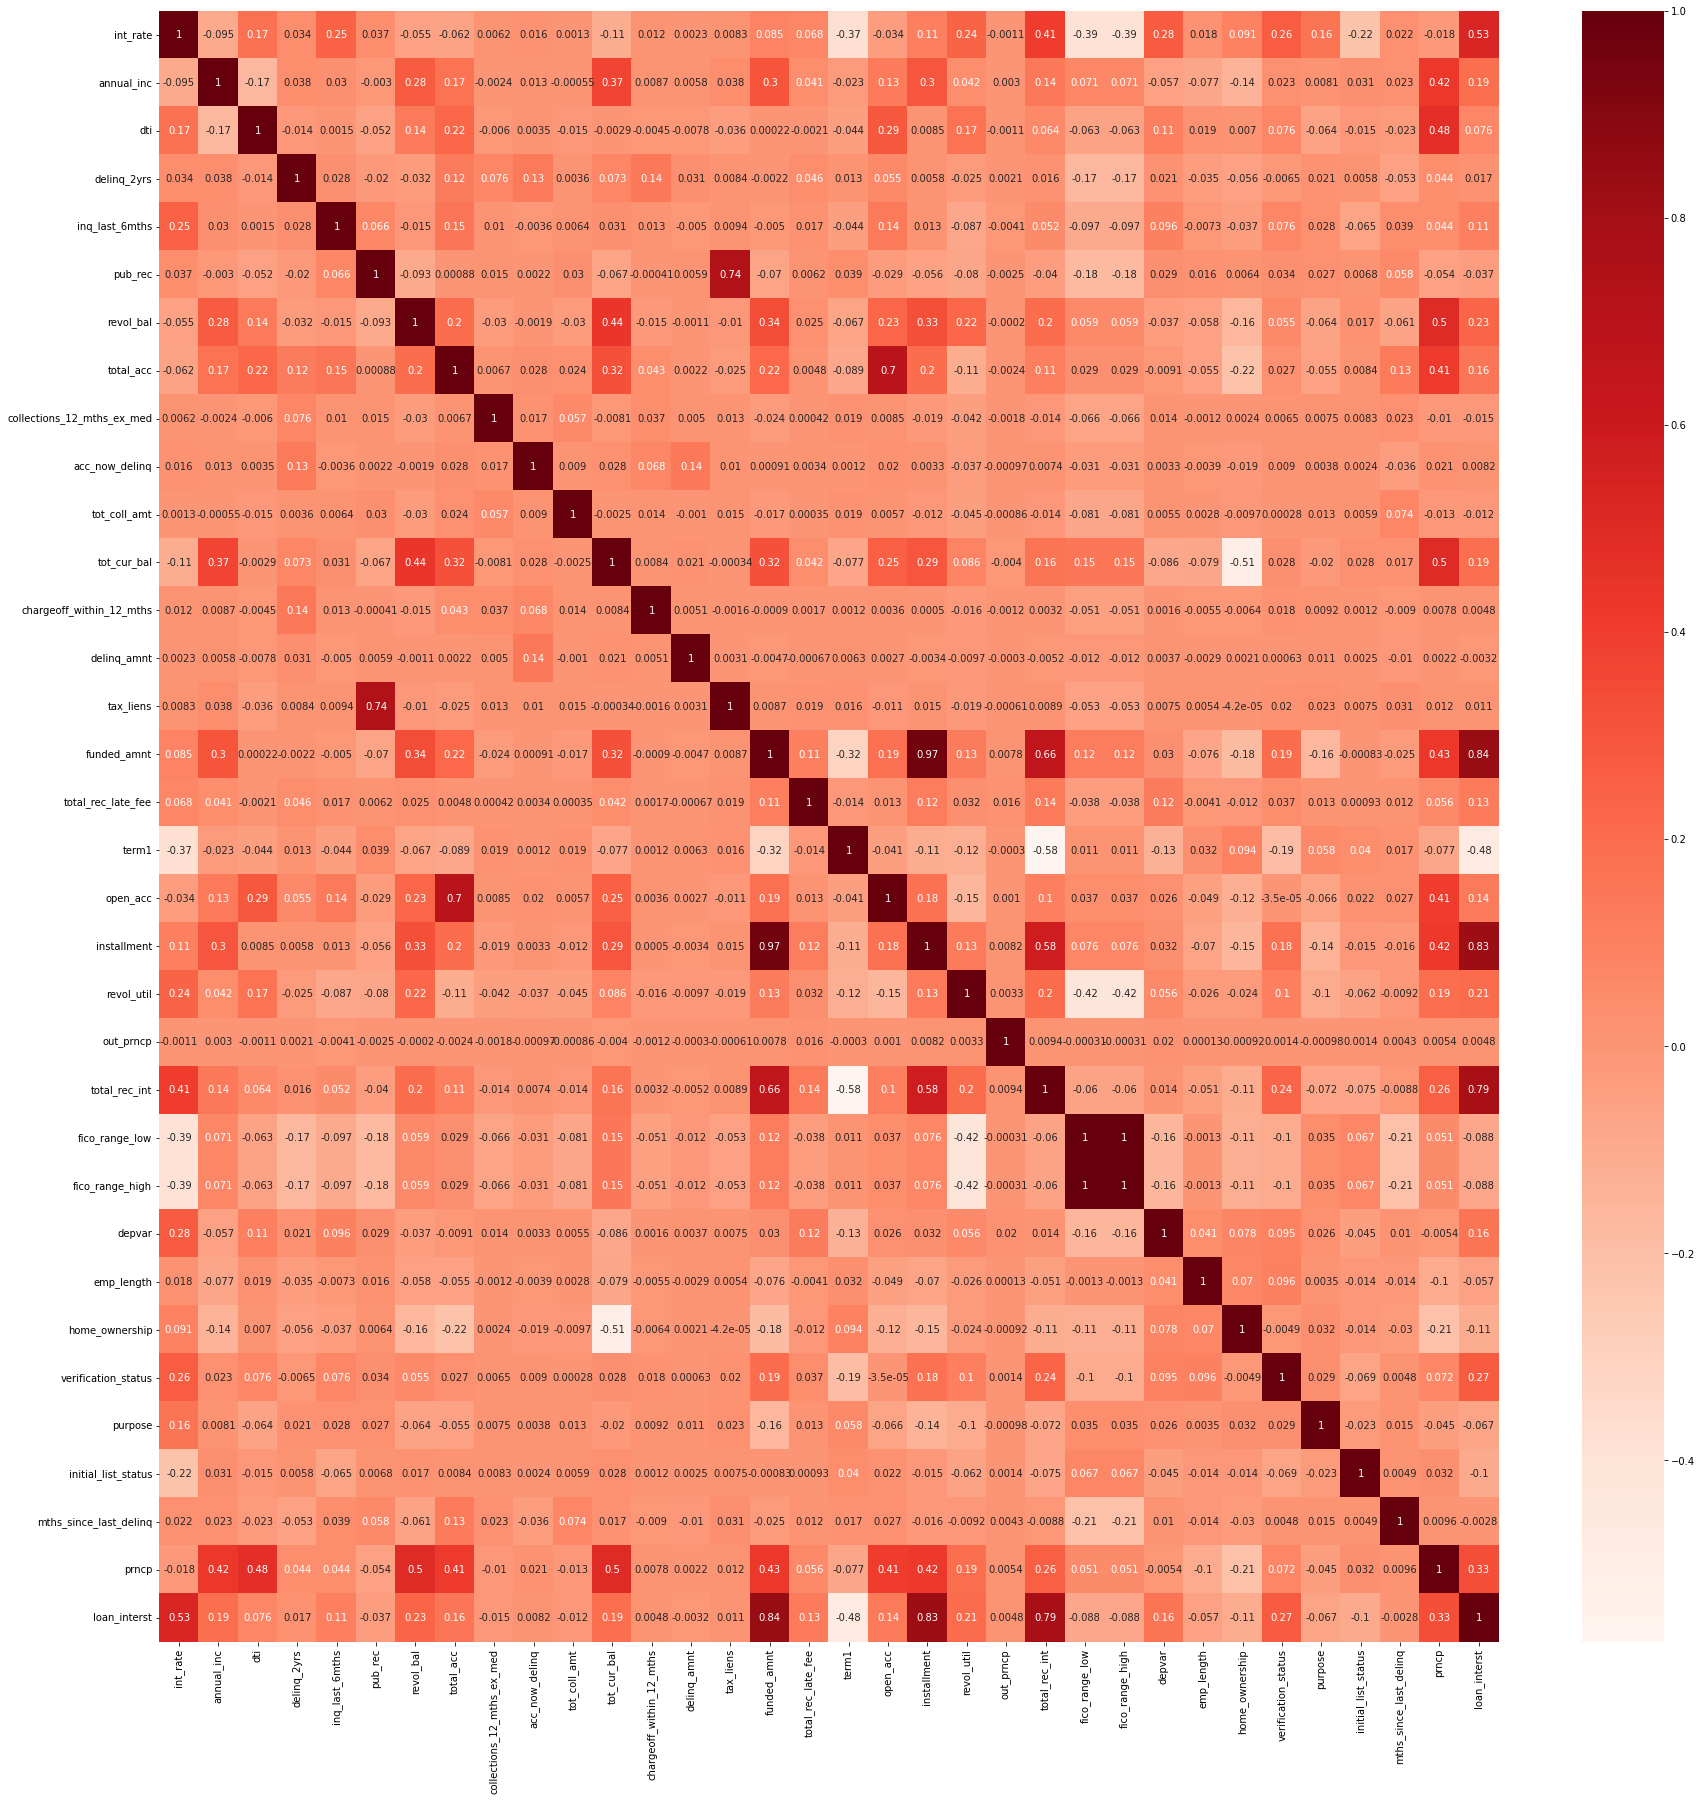

In [ ]:
#상관관계 확인
plt.figure(figsize = (30,30))
sns.heatmap(df.corr(), annot=True, cmap='Reds')
plt.show()

## 이상치 탐지

IndexError: ignored

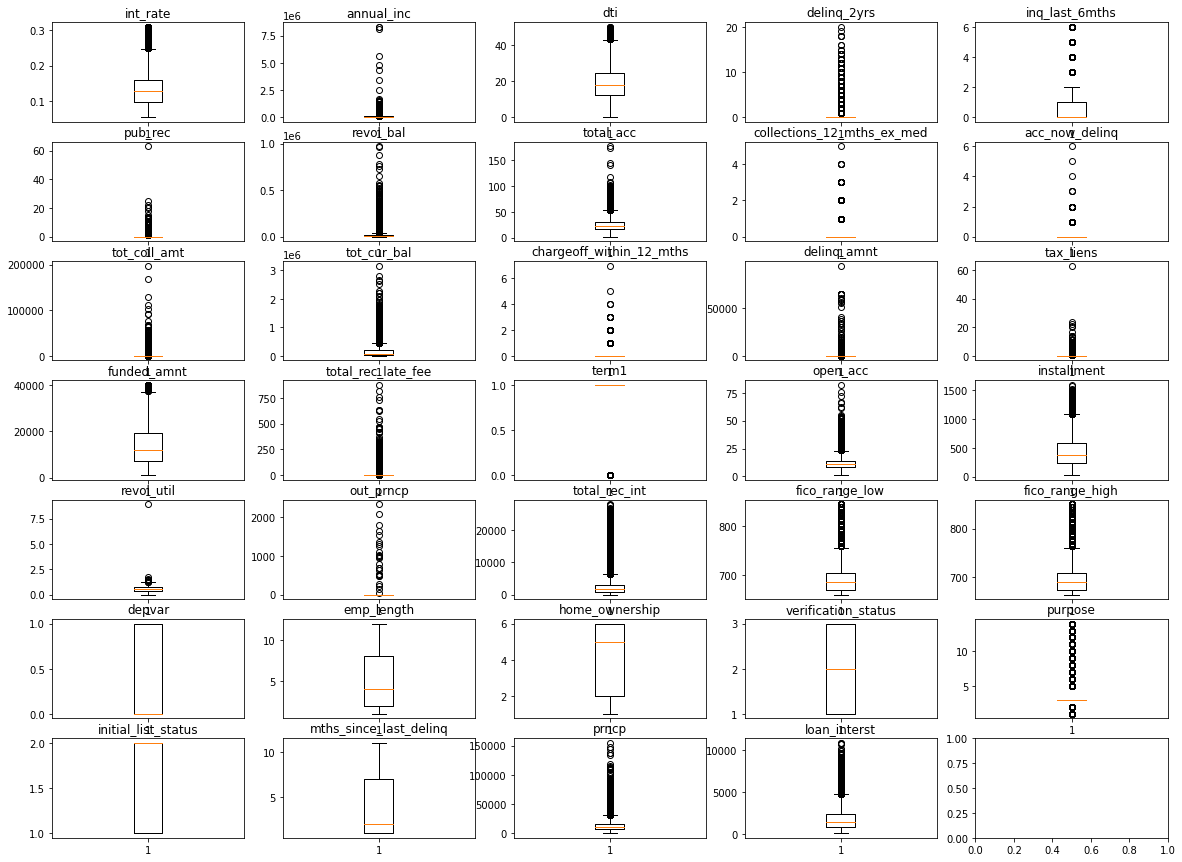

In [ ]:
# 각 feature별로 이상치 확인
n = 0
f, grid = plt.subplots(7, 5, figsize=(20, 15))
for row in grid:
    for ax in row:
        col = df.columns[n]
        ax.boxplot(df[col])
        ax.set_title(col)
        n += 1

In [ ]:
# feature별로 한쪽으로 치우쳐져있는지 확인
n = 0
f, grid = plt.subplots(7, 5, figsize=(20, 15))
for row in grid:
    for ax in row:
        col = df.columns[n]
        ax.hist(df[col])
        ax.set_title(col)
        n += 1

In [ ]:
#skewness(왜도) 확인
skewness = df.apply(lambda x: x.skew()).sort_values(ascending=False)
skewness

out_prncp                     85.444539
delinq_amnt                   64.487667
annual_inc                    50.785630
tax_liens                     35.837090
tot_coll_amt                  32.054640
acc_now_delinq                19.793467
total_rec_late_fee            18.331486
chargeoff_within_12_mths      15.638461
pub_rec                       14.146254
revol_bal                     10.402807
collections_12_mths_ex_med     9.594333
delinq_2yrs                    4.985413
total_rec_int                  2.788552
tot_cur_bal                    2.689505
purpose                        2.267498
prncp                          2.204362
inq_last_6mths                 1.689340
loan_interst                   1.659829
fico_range_high                1.419333
fico_range_low                 1.419130
open_acc                       1.343696
installment                    1.063023
total_acc                      0.983705
funded_amnt                    0.870343
mths_since_last_delinq         0.840382


## 정규화
1. 한쪽으로 치우침이 있어서 로그변환을 했더니 **성능이 저하**되는것을 확인되어서 이상치 영향만 안받게 하려고 정규화를 시도함.
2. **RobustScaler 사용**<br>
중앙값(median)과 IQR(interquartile range)을 사용하여서 이상치의 영향을 받지 않아서 사용하게되었음.

In [ ]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
sc_df = rs.fit_transform(df)
sc_df2 = rs.fit_transform(df2)

sc_df = pd.DataFrame(sc_df, index=df.index, columns=df.columns)
sc_df2 = pd.DataFrame(sc_df2, index=df2.index, columns=df2.columns)

In [ ]:
sc_df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,fico_range_high,depvar,emp_length,home_ownership,verification_status,purpose,initial_list_status,mths_since_last_delinq,prncp,loan_interst
0,-0.743802,-0.911111,0.902676,0.0,1.0,0.0,-0.592307,0.200000,0.0,0.0,0.0,-0.336184,0.0,0.0,0.0,-0.900000,0.0,0.0,1.166667,-0.979326,-1.295265,0.0,-0.667891,2.285714,2.285714,0.0,-0.500000,0.25,0.0,-1.0,0.0,-0.166667,-0.517100,-0.818351
1,0.041322,0.400000,-1.073804,0.0,1.0,1.0,-0.392321,0.066667,0.0,0.0,0.0,-0.275809,0.0,0.0,0.0,-0.333333,0.0,0.0,-0.500000,-0.288616,-0.261838,0.0,0.039994,-0.571429,-0.571429,0.0,-0.333333,0.25,0.5,0.0,0.0,-0.166667,-0.759520,-0.220909
2,0.041322,-0.533333,0.454177,0.0,3.0,0.0,-0.334011,-0.333333,0.0,0.0,0.0,-0.216085,0.0,0.0,0.0,-0.583333,0.0,0.0,-0.666667,-0.589807,0.944290,0.0,-0.251405,-0.428571,-0.428571,0.0,0.000000,0.25,0.0,0.0,0.0,1.500000,-0.212100,-0.468509
3,0.153719,0.844444,-0.145174,4.0,2.0,0.0,-0.309031,0.466667,0.0,0.0,0.0,1.542101,0.0,0.0,0.0,0.250000,0.0,0.0,0.166667,0.428826,-0.233983,0.0,-0.164505,-0.142857,-0.142857,1.0,-0.166667,-0.75,0.5,0.0,0.0,0.500000,0.563934,0.421632
4,-0.008264,-0.711111,0.585564,0.0,1.0,2.0,-0.209408,-0.733333,0.0,0.0,2506.0,-0.353713,0.0,0.0,0.0,-0.166667,0.0,0.0,-0.500000,-0.092142,-0.348189,0.0,-0.341054,-0.714286,-0.714286,1.0,0.000000,0.25,0.0,0.0,0.0,-0.166667,-0.362079,-0.074903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.798347,0.066667,-0.031630,0.0,3.0,1.0,0.016592,-0.133333,1.0,0.0,0.0,-0.247749,0.0,0.0,0.0,0.666667,0.0,0.0,0.333333,1.050102,0.665738,0.0,1.722473,-0.714286,-0.714286,1.0,0.500000,0.25,0.5,0.0,0.0,-0.166667,0.053859,1.351482
99996,-0.634711,0.066667,-1.231144,0.0,0.0,0.0,-0.659633,-0.733333,0.0,0.0,0.0,-0.369861,0.0,0.0,0.0,-0.500000,0.0,0.0,-0.666667,-0.524038,-1.172702,0.0,-0.357270,2.285714,2.285714,0.0,1.166667,0.25,0.0,0.0,-1.0,-0.166667,-0.971034,-0.541893
99997,0.123967,-0.355556,1.140308,0.0,1.0,0.0,-0.150211,-0.200000,0.0,0.0,0.0,0.170376,0.0,0.0,0.0,-0.466667,0.0,0.0,1.333333,-0.444650,0.284123,0.0,-0.162016,-0.571429,-0.571429,0.0,0.000000,0.25,-0.5,-1.0,0.0,-0.166667,0.404574,-0.332630
99998,1.390083,-0.688889,-1.097324,0.0,1.0,0.0,-0.528823,-1.266667,0.0,0.0,0.0,-0.383386,0.0,0.0,0.0,-0.541667,0.0,0.0,-1.333333,-0.473020,0.529248,0.0,-0.118007,0.714286,0.714286,1.0,1.333333,0.25,0.5,7.0,0.0,-0.166667,-1.020896,-0.142092


In [ ]:
sc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  float64
 4   inq_last_6mths              100000 non-null  float64
 5   pub_rec                     100000 non-null  float64
 6   revol_bal                   100000 non-null  float64
 7   total_acc                   100000 non-null  float64
 8   collections_12_mths_ex_med  100000 non-null  float64
 9   acc_now_delinq              100000 non-null  float64
 10  tot_coll_amt                100000 non-null  float64
 11  tot_cur_bal                 100000 non-null  float64
 12  chargeoff_within_12_mths    100000 non-null  float64
 13  delinq_amnt    

# Train Valid Split

In [ ]:
#데이터 프레임을 다시설정 한 후 학습해야함!
X = sc_df.drop('depvar', axis=1)
y = sc_df['depvar']

In [ ]:
#data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# training set과 validation set의 데이터 수 확인
print("training set length : ", len(X_train))
print("valid set length : ", len(X_valid))

training set length :  80000
valid set length :  20000


In [ ]:
# validation set의 라벨 비율 확인
y_valid.sum() / len(y_valid)

0.3265

# Model

##1. LightGBM

* 앞서 파라미터 튜닝를 썼을 때 F1- score가 좋은 걸 확인하였음!

In [ ]:
# # 최적의 하이퍼 파라미터 찾기
# lgb_clf = LGBMClassifier(tree_method= 'gpu_hist')

# param_grid = {'max_depth':[10, 15, 20],
#               'n_estimators':[150, 250, 350]
#               }

# cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

# grid_search = GridSearchCV(estimator=lgb_clf,
#                            param_grid=param_grid, 
#                            n_jobs=-1,
#                            cv=cv,
#                            scoring='f1_macro', 
#                            error_score=0) 

# results = grid_search.fit(X_train, y_train)

# print("최적의 하이퍼 파라미터 : " ,results.best_params_)
# print("최고 f1-score : {0:.4f}" .format(results.best_score_))

In [ ]:
# best parameter를 사용하여 prediction 수행
lgb_clf = LGBMClassifier(max_depth = 15,
                         n_estimators = 350,
                         eval_metric='logloss',
                        objective= 'binary',
                         tree_method='gpu_hist',
                        seed=42
                         )

lgb_clf.fit(X_train, y_train)

y_pred_lgb = lgb_clf.predict(X_valid)

In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7593
정밀도: 0.6715
재현율: 0.5145
AUC: 0.6962
F1: 0.7068


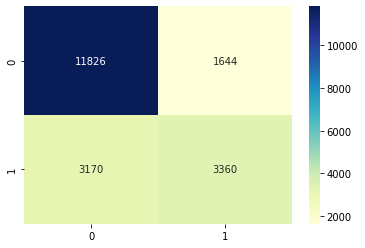

In [ ]:
get_clf_eval(y_valid, y_pred_lgb)

## 2. Xgboost

In [ ]:
# # 하이퍼 파라미터 튜닝
# xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

# param_grid = {'max_depth':[5, 10, 20],
#               'n_estimators':[100, 150]
#               }

# cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

# grid_search = GridSearchCV(estimator=xgb_clf,
#                            param_grid=param_grid, 
#                            n_jobs=-1,
#                            cv=cv,
#                            scoring='f1_macro', 
#                            error_score=0) 

# results=grid_search.fit(X_train, y_train)

# results.best_params_

# print("최적의 하이퍼 파라미터 : " ,results.best_params_)
# print("최고 f1-score : {0:.4f}" .format(results.best_score_))

In [ ]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = 10,
                                n_estimators = 150,
                                eval_metric='logloss',
                                tree_method='gpu_hist',
                                predictor='gpu_predictor')

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_valid)


정확도: 0.7530
정밀도: 0.6571
재현율: 0.5095
AUC: 0.6903
F1: 0.7001


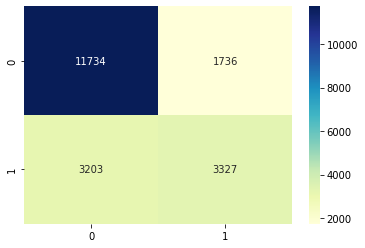

In [ ]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)

## 3. stacking


정확도: 0.7577
정밀도: 0.6805
재현율: 0.4862
AUC: 0.6878
F1: 0.6995


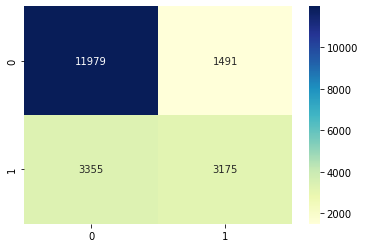

In [ ]:
stacking_clf = StackingClassifier(estimators=[('lgbm', lgb_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = stacking_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.97433063, 0.02566937],
       [0.55589911, 0.44410089],
       [0.97282834, 0.02717166],
       ...,
       [0.33128806, 0.66871194],
       [0.90625487, 0.09374513],
       [0.65742659, 0.34257341]])


정확도: 0.7493
정밀도: 0.6039
재현율: 0.6744
AUC: 0.7300
F1: 0.7229


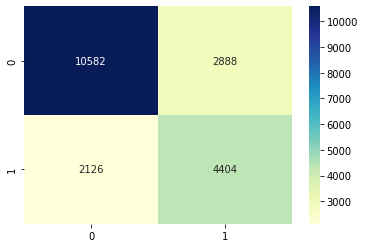

In [ ]:
# threshold 변경 및 성능 확인
get_clf_eval(y_valid, y_pred_prob[:,1]>0.41)

## Permutation Importance

* 전처리 과정에서 featrue importance를 써서 중요도를 확인해보았으나, 중요도가 낮은 feature을 제거하고 모델을 찾으려니 시간을 너무 많이 잡아서 적당한 모델을 찾고 permutation Importance를 써서 Feature Importance를 확인해보려고함.

In [ ]:
#feature importance 확인해보기
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(stacking_clf, scoring ="f1", random_state=42).fit(X_valid, y_valid)
eli5.show_weights(perm, top = 40, feature_names = X_valid.columns.tolist())

Weight,Feature
0.1353 ± 0.0060,loan_interst
0.1116 ± 0.0090,total_rec_int
0.0787 ± 0.0046,int_rate
0.0725 ± 0.0019,total_rec_late_fee
0.0336 ± 0.0031,term1
0.0136 ± 0.0065,dti
0.0111 ± 0.0041,fico_range_low
0.0101 ± 0.0022,open_acc
0.0078 ± 0.0044,tot_cur_bal
0.0071 ± 0.0049,annual_inc


In [ ]:
#중요도가 0미만 제거!
perm_df = df.drop(['fico_range_high','collections_12_mths_ex_med','initial_list_status','tot_coll_amt','prncp', 'revol_bal', 'purpose'], axis=1)
perm_df2 = df2.drop(['fico_range_high','collections_12_mths_ex_med','initial_list_status','tot_coll_amt','prncp', 'revol_bal', 'purpose'], axis=1)
perm_df

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_acc,acc_now_delinq,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,total_rec_int,fico_range_low,depvar,emp_length,home_ownership,verification_status,mths_since_last_delinq,loan_interst
0,0.0824,21000.0,29.19,0,1,0,26,0,11773,0,0,0,1200,0.0,1,18,37.74,0.076,0.0,157.94,765,0,1,6,2,1,98.8800
1,0.1299,80000.0,4.82,0,1,1,24,0,21875,0,0,0,8000,0.0,1,8,269.52,0.447,0.0,1702.42,665,0,2,6,3,1,1039.2000
2,0.1299,38000.0,23.66,0,3,0,18,0,31868,0,0,0,5000,0.0,1,7,168.45,0.880,0.0,1066.64,670,0,4,6,2,11,649.5000
3,0.1367,100000.0,16.27,4,2,0,30,0,326049,0,0,0,15000,0.0,1,12,510.27,0.457,0.0,1256.24,680,1,3,2,3,5,2050.5000
4,0.1269,30000.0,25.28,0,1,2,12,0,8840,0,0,0,10000,0.0,1,8,335.45,0.416,0.0,871.04,660,1,4,6,2,1,1269.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,21,0,26570,0,0,0,20000,0.0,1,13,718.75,0.780,0.0,5373.29,660,1,7,6,3,1,3514.0000
99996,0.0890,65000.0,2.88,0,0,0,12,0,6138,0,0,0,6000,0.0,1,7,190.52,0.120,0.0,835.66,765,0,11,6,2,1,534.0000
99997,0.1349,46000.0,32.12,0,1,0,20,0,96531,0,0,0,6400,0.0,1,19,217.16,0.643,0.0,1261.67,665,0,4,6,1,1,863.3600
99998,0.2115,31000.0,4.53,0,1,0,4,0,3875,0,0,0,5500,0.0,1,3,207.64,0.731,0.0,1357.69,710,1,12,6,3,1,1163.2500


## feature 조정 후 Model 확인

In [ ]:
#데이터 프레임을 다시설정 한 후 학습해야함!
X = perm_df.drop('depvar', axis=1)
y = perm_df['depvar']

#data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# LightGBM
lgb_clf = LGBMClassifier(max_depth = 15,
                         n_estimators = 350,
                         eval_metric='logloss',
                        objective= 'binary',
                         tree_method='gpu_hist',
                        seed=42
                         )

lgb_clf.fit(X_train, y_train)

y_pred_lgb = lgb_clf.predict(X_valid)

# Xgboost
xgb_clf = xgboost.XGBClassifier(max_depth = 10,
                                n_estimators = 150,
                                eval_metric='logloss',
                                tree_method='gpu_hist',
                                predictor='gpu_predictor')

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_valid)

#stacking
stacking_clf = StackingClassifier(estimators=[('lgbm', lgb_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)


정확도: 0.7562
정밀도: 0.6584
재현율: 0.5077
AUC: 0.6911
F1: 0.7013

정확도: 0.7503
정밀도: 0.6437
재현율: 0.5065
AUC: 0.6865
F1: 0.6958

정확도: 0.7550
정밀도: 0.6506
재현율: 0.5200
AUC: 0.6935
F1: 0.7027


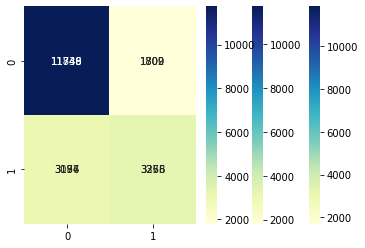

In [ ]:
# 성능 확인
get_clf_eval(y_valid, y_pred_lgb)
get_clf_eval(y_valid, y_pred_xgb)
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = stacking_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.26002105, 0.73997895],
       [0.93854401, 0.06145599],
       [0.92775661, 0.07224339],
       ...,
       [0.96406292, 0.03593708],
       [0.79315159, 0.20684841],
       [0.93681555, 0.06318445]])


정확도: 0.7440
정밀도: 0.5928
재현율: 0.6589
AUC: 0.7217
F1: 0.7150


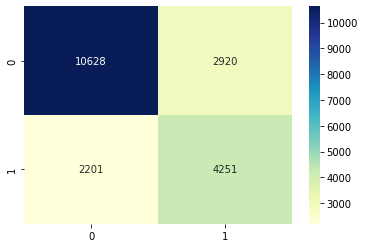

In [ ]:
# threshold 변경 및 성능 확인
get_clf_eval(y_valid, y_pred_prob[:,1]>0.41)

In [ ]:
# proba 형식 구하기(stacking)
lgb_pred = lgb_clf.predict_proba(perm_df2.drop(columns=['ID']))
prob = (lgb_pred[:,1]>0.41) 
print(prob)
arr = []
for i in prob:
  if i == True:
    i = 1
    arr.append(i)
  else:
    i = 0
    arr.append(i)

print(arr)
df_arr = pd.DataFrame(arr)
df_arr[0].to_numpy()

[ True  True  True ... False False False]
[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/모의경진대회/대부업체 고객 데이터 통한 채무 불이행 예측/data/sample_submission.csv')

# prediction 수행
submit['answer'] = df_arr[0].to_numpy()

# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/모의경진대회/대부업체 고객 데이터 통한 채무 불이행 예측/data/28번_perm_stacking2_submission.csv', index=False)